<a href="https://colab.research.google.com/github/MamadouBousso/IAProjects/blob/master/Convolutional_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. We'll build a convolutional autoencoder to compress the MNIST dataset. 

>The encoder portion will be made of convolutional and pooling layers and the decoder will be made of **transpose convolutional layers** that learn to "upsample" a compressed representation.

<img src='notebook_ims/autoencoder_1.png' />
![Capture d’écran 2021-07-08 à 23.04.15.png]

In [2]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

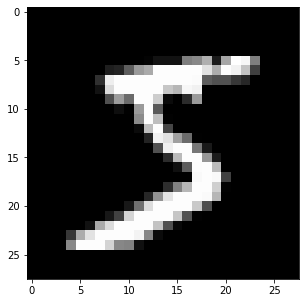

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---


## Autoencodeur convolutif

#### Encodeur
La partie encodeur du réseau sera une pyramide convolutive. Chaque couche convolutive sera suivie d'une couche de max-pooling pour réduire les dimensions des couches.

#### Décodeur

Le décodeur pourrait être quelque chose de nouveau pour vous. Le décodeur doit passer d'une représentation d'image compressée à une image reconstruite. Par exemple, la représentation pourrait être une couche max-pool 7x7x4 qui est la sortie de l'encodeur, mais aussi l'entrée du décodeur. Nous voulons obtenir une image 28x28x1 du décodeur, nous devons donc remonter à partir de la représentation compressée. Un schéma du réseau est présenté ci-dessous.

<img src='notebook_ims/conv_enc_1.png' width=640px>

Ici, notre couche d'encodeur finale a une taille de 7x7x4 = 196. Les images originales ont une taille de 28x28 = 784, de sorte que le vecteur encodé correspond à 25% de la taille de l'image originale. Ce ne sont que des tailles suggérées pour chacune des couches. N'hésitez pas à modifier les profondeurs et les tailles, en fait, vous êtes encouragé à ajouter des couches supplémentaires pour rendre cette représentation encore plus petite ! N'oubliez pas que notre objectif ici est de trouver une petite représentation des données d'entrée.



### Transpose Convolutions, Decodeur

Ce décodeur utilise des couches **convolutives transposées** pour augmenter la largeur et la hauteur des couches d'entrée. Ils fonctionnent presque exactement de la même manière que les couches convolutives, mais à l'envers. Un stride dans la couche d'entrée entraîne un stride plus important dans la couche de convolution transposée. Par exemple, si vous avez un noyau 3x3, un patch 3x3 dans la couche d'entrée sera réduit à une unité dans une couche convolutive. Comparativement, une unité dans la couche d'entrée sera étendue à un chemin 3x3 dans une couche de convolution transposée. PyTorch nous fournit un moyen simple de créer les couches,[`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/nn.html#convtranspose2d). 


Il est important de noter que la transposition des couches de convolution peut entraîner des artefacts dans les images finales, tels que des motifs en damier. Ceci est dû au chevauchement dans les noyaux qui peut être évité en définissant une même taille pour le stride et la taille du noyau. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) d'après Augustus Odena, *et al*, les auteurs montrent que ces artefacts en damier peuvent être évités en redimensionnant les couches en utilisant le plus proche voisin ou une interpolation bilinéaire (suréchantillonnage) suivie d'une couche convolutive.

> Nous montrerons cette approche dans un autre notebook, afin que vous puissiez l'expérimenter et voir la différence.
#### À FAIRE : Construisez le réseau illustré ci-dessus.
> Construisez l'encodeur à partir d'une série de couches convolutives et de mise en commun.
> Lors de la construction du décodeur, rappelez-vous que les couches convolutives transposées peuvent suréchantillonner une entrée d'un facteur 2 en utilisant un stride et un noyau de taille  2.




In [35]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        
        self.maxpool = nn.MaxPool2d(2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        
        
        ## decode ##
        ## apply ReLu to all hidden layers *except for the output layer
        ## apply a sigmoid to the output layer
        x = self.t_conv1(x)
        x = self.t_conv2(x)
        x = torch.sigmoid(x)        
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


---
## Training

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards. 

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

Otherwise, this is pretty straightfoward training with PyTorch. Since this is a convlutional autoencoder, our images _do not_ need to be flattened before being passed in an input to our model.

In [36]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.213283
Epoch: 2 	Training Loss: 0.067630
Epoch: 3 	Training Loss: 0.059735
Epoch: 4 	Training Loss: 0.055744
Epoch: 5 	Training Loss: 0.053215
Epoch: 6 	Training Loss: 0.051653
Epoch: 7 	Training Loss: 0.050501
Epoch: 8 	Training Loss: 0.049657
Epoch: 9 	Training Loss: 0.049003
Epoch: 10 	Training Loss: 0.048453
Epoch: 11 	Training Loss: 0.047983
Epoch: 12 	Training Loss: 0.047570
Epoch: 13 	Training Loss: 0.047210
Epoch: 14 	Training Loss: 0.046891
Epoch: 15 	Training Loss: 0.046614
Epoch: 16 	Training Loss: 0.046373
Epoch: 17 	Training Loss: 0.046163
Epoch: 18 	Training Loss: 0.045973
Epoch: 19 	Training Loss: 0.045803
Epoch: 20 	Training Loss: 0.045648
Epoch: 21 	Training Loss: 0.045500
Epoch: 22 	Training Loss: 0.045355
Epoch: 23 	Training Loss: 0.045198
Epoch: 24 	Training Loss: 0.045048
Epoch: 25 	Training Loss: 0.044913
Epoch: 26 	Training Loss: 0.044787
Epoch: 27 	Training Loss: 0.044671
Epoch: 28 	Training Loss: 0.044558
Epoch: 29 	Training Loss: 0.0

## Checking out the results

Below I've plotted some of the test images along with their reconstructions. These look a little rough around the edges, likely due to the checkerboard effect we mentioned above that tends to happen with transpose layers.

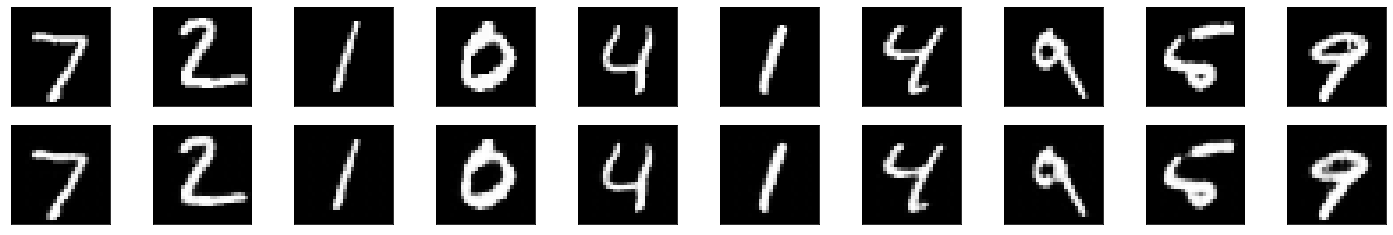

In [38]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)